# Q.3 Understanding the choice of kernel

In [1]:
#All imports

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import collections
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, IntSlider

In [2]:
#Generate 100 data points (function in part a)
########################################

x = np.random.uniform(0,1,100)
y = np.sin(2*np.pi*x)
gaussian_noise = np.random.normal(0,0.1,100)
y_noised = y + gaussian_noise
df = pd.DataFrame({'x':x, 'y':y_noised})\

# Obtaining train and test splits
train_df = df.iloc[::2].reset_index(drop=True)
test_df = df.iloc[1::2].reset_index(drop=True)

X_train = train_df['x']
Y_train = train_df['y']
X_test = test_df['x']
Y_test = test_df['y']

mean = np.mean(X_train)
std_dev = np.std(X_train)
X_train = (X_train - mean) / std_dev
X_test = (X_test - mean) / std_dev

In [3]:
#Generate 100 data points (function in part b)
########################################

x1 = np.random.uniform(0, 3, 100)
y1_true = np.zeros_like(x)

mask1 = (x1 >= 0) & (x1 < 1)
mask2 = (x1 >= 1) & (x1 < 2)
mask3 = (x1 >= 2) & (x1 <= 3)

y1_true[mask1] = np.sin(2 * np.pi * x1[mask1])
y1_true[mask2] = 1 - 2 * np.abs(x1[mask2] - 1.5)
y1_true[mask3] = np.exp(-((x1[mask3] - 2.5) ** 2) / (2 * 0.1 ** 2))

y1 = y1_true + np.random.normal(0, 0.1, 100)

df1 = pd.DataFrame({'x1':x1, 'y1':y1})
train_df1 = df1.iloc[::2].reset_index(drop=True)
test_df1 = df1.iloc[1::2].reset_index(drop=True)
X_train1 = train_df1['x1']
Y_train1 = train_df1['y1']
X_test1 = test_df1['x1']
Y_test1 = test_df1['y1']

mean1 = np.mean(X_train1)
std_dev1 = np.std(X_train1)
X_train1 = (X_train1 - mean1) / std_dev1
X_test1 = (X_test1 - mean1) / std_dev1

In [4]:
def polynomial_features(X,M):
  features = np.zeros((len(X),M+1))
  for i in range(M+1):
    features[:,i] = X**i
  return features

def gaussian_features(X,M):
  if M==0:
    return np.ones((len(X),1))
  centers = np.linspace(np.min(X),np.max(X),M)
  sigma = (np.max(X)-np.min(X))/M * 1
  features = np.zeros((len(X),M))
  for j in range(M):
    mu_j = centers[j]
    features[:,j] = np.exp(-(X-mu_j)**2/(2 * sigma**2))
  features = np.hstack([np.ones((len(X),1)),features])
  return features

def sigmoidal_features(X,M):
  if(M ==0):
    return np.ones((len(X),1))
  centers = np.linspace(np.min(X),np.max(X),M)
  a = M / (np.max(X)-np.min(X))
  features = np.zeros((len(X),M))
  for j in range(M):
    a_j = centers[j]
    features[:,j] = 1/(1+np.exp(-a*(X-a_j)))
  features = np.hstack([np.ones((len(X),1)),features])
  return features

def KernelRegressionFit(X_train,Y_train,kernel,M,lamda = 0 ):
  if kernel == 'polynomial':
    X = polynomial_features(X_train,M)
  elif kernel =='gaussian':
    X = gaussian_features(X_train,M)
  elif kernel == 'sigmoidal':
    X = sigmoidal_features(X_train,M)
  I = np.eye(X.shape[1])
  if lamda == 0 :
    w_opt = np.linalg.pinv(X.T @ X) @ X.T @ Y_train
  else :
    w_opt = np.linalg.pinv(X.T @ X + lamda*I) @ X.T @ Y_train
  return w_opt

def KernelRegressionPred_Error(w_est, X_train, Y_train, X_test, Y_test, kernelType):
    M = len(w_est) - 1
    if kernelType == 'polynomial':
        X_tr = polynomial_features(X_train, M)
        X_te = polynomial_features(X_test, M)
    elif kernelType == 'gaussian':
        X_tr = gaussian_features(X_train, M)
        X_te = gaussian_features(X_test, M)
    elif kernelType == 'sigmoidal':
        X_tr = sigmoidal_features(X_train, M)
        X_te = sigmoidal_features(X_test, M)

    Y_tr_pred = X_tr @ w_est
    Y_te_pred = X_te @ w_est
    train_error = np.sqrt(np.mean((Y_tr_pred - Y_train)**2))
    test_error = np.sqrt(np.mean((Y_te_pred - Y_test)**2))
    return train_error, test_error

def KernelRegressionPred(w_est, X_train, Y_train, X_test, Y_test, kernelType):
    M = len(w_est) - 1
    if kernelType == 'polynomial':
        X_tr = polynomial_features(X_train, M)
        X_te = polynomial_features(X_test, M)
    elif kernelType == 'gaussian':
        X_tr = gaussian_features(X_train, M)
        X_te = gaussian_features(X_test, M)
    elif kernelType == 'sigmoidal':
        X_tr = sigmoidal_features(X_train, M)
        X_te = sigmoidal_features(X_test, M)

    Y_tr_pred = X_tr @ w_est
    Y_te_pred = X_te @ w_est
    return Y_tr_pred , Y_te_pred

In [5]:
# Plotting graphs for part a

M_range=list(range(1,10))

polynomial_tr_error = []
polynomial_te_error = []
gaussian_tr_error = []
gaussian_te_error = []
sigmoid_tr_error = []
sigmoid_te_error = []

polynomial_tr_pred= []
polynomial_te_pred = []
gaussian_tr_pred = []
gaussian_te_pred = []
sigmoid_tr_pred = []
sigmoid_te_pred = []

for m in  M_range:
  w_polynomial = KernelRegressionFit(X_train,Y_train,'polynomial',m,0)
  Y_train_pred , Y_test_pred = KernelRegressionPred(w_polynomial, X_train, Y_train, X_test, Y_test,'polynomial')
  tr_err, te_err = KernelRegressionPred_Error(w_polynomial,X_train,Y_train,X_test,Y_test,'polynomial')
  polynomial_tr_error.append(tr_err)
  polynomial_te_error.append(te_err)
  polynomial_tr_pred.append(Y_train_pred)
  polynomial_te_pred.append(Y_test_pred)

  w_gaussian = KernelRegressionFit(X_train,Y_train,'gaussian',m,0)
  Y_train_pred , Y_test_pred = KernelRegressionPred(w_gaussian, X_train, Y_train, X_test, Y_test,'gaussian')
  tr_err, te_err = KernelRegressionPred_Error(w_gaussian,X_train,Y_train,X_test,Y_test,'gaussian')
  gaussian_tr_error.append(tr_err)
  gaussian_te_error.append(te_err)
  gaussian_tr_pred.append(Y_train_pred)
  gaussian_te_pred.append(Y_test_pred)

  w_sigmoidal= KernelRegressionFit(X_train,Y_train,'sigmoidal',m,0)
  Y_train_pred , Y_test_pred = KernelRegressionPred(w_sigmoidal, X_train, Y_train, X_test, Y_test,'sigmoidal')
  tr_err, te_err = KernelRegressionPred_Error(w_sigmoidal,X_train,Y_train,X_test,Y_test,'sigmoidal')
  sigmoid_tr_error.append(tr_err)
  sigmoid_te_error.append(te_err)
  sigmoid_tr_pred.append(Y_train_pred)
  sigmoid_te_pred.append(Y_test_pred)

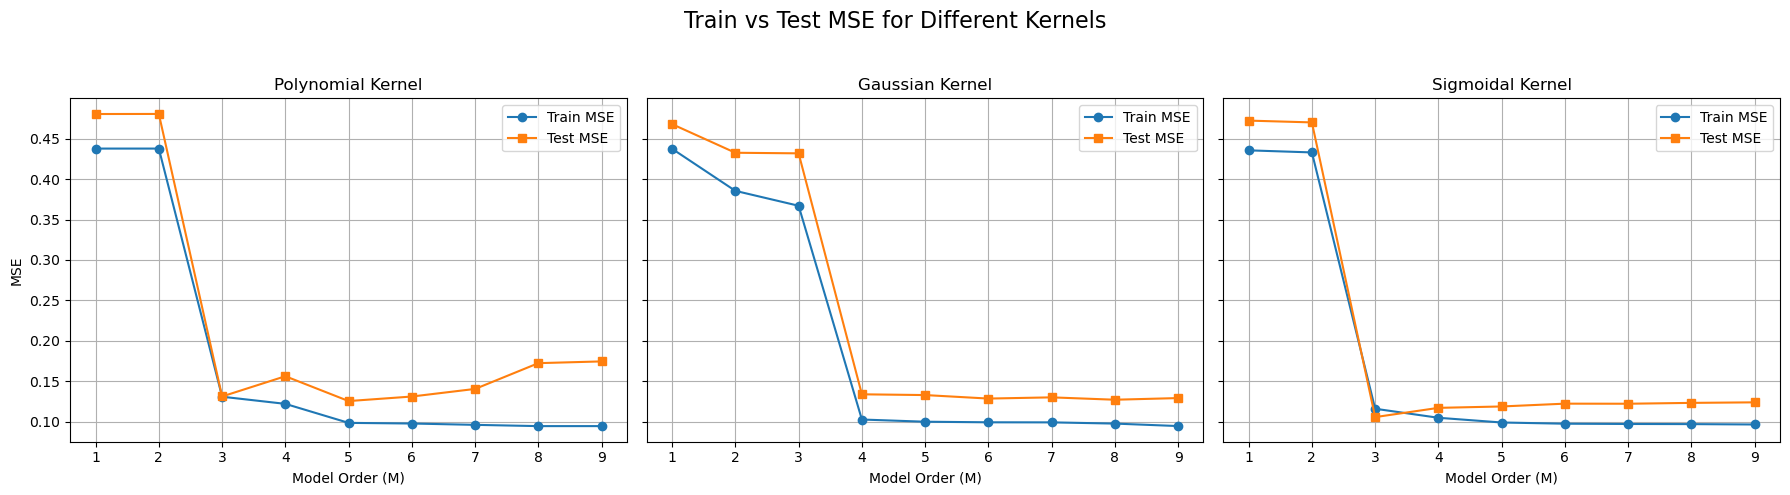

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# --- Plot 1: Polynomial Kernel Errors ---
axs[0].plot(M_range, polynomial_tr_error, 'o-', label='Train MSE')
axs[0].plot(M_range, polynomial_te_error, 's-', label='Test MSE')
axs[0].set_title('Polynomial Kernel')
axs[0].set_xlabel('Model Order (M)')
axs[0].set_ylabel('MSE')
axs[0].grid(True)
axs[0].legend()

# --- Plot 2: Gaussian Kernel Errors ---
axs[1].plot(M_range, gaussian_tr_error, 'o-', label='Train MSE')
axs[1].plot(M_range, gaussian_te_error, 's-', label='Test MSE')
axs[1].set_title('Gaussian Kernel')
axs[1].set_xlabel('Model Order (M)')
axs[1].grid(True)
axs[1].legend()

# --- Plot 3: Sigmoidal Kernel Errors ---
axs[2].plot(M_range, sigmoid_tr_error, 'o-', label='Train MSE')
axs[2].plot(M_range, sigmoid_te_error, 's-', label='Test MSE')
axs[2].set_title('Sigmoidal Kernel')
axs[2].set_xlabel('Model Order (M)')
axs[2].grid(True)
axs[2].legend()

plt.suptitle('Train vs Test MSE for Different Kernels', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

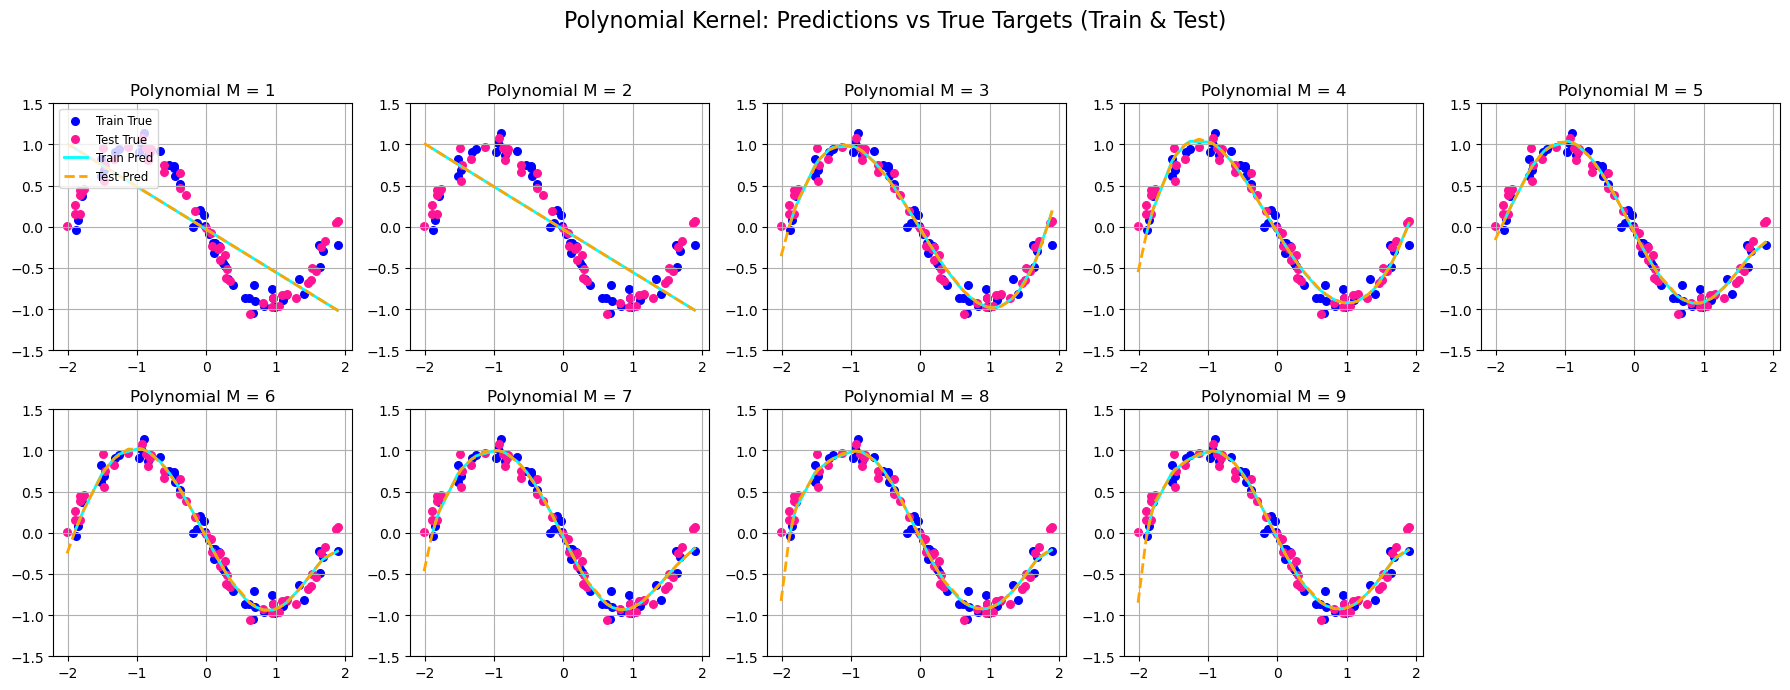

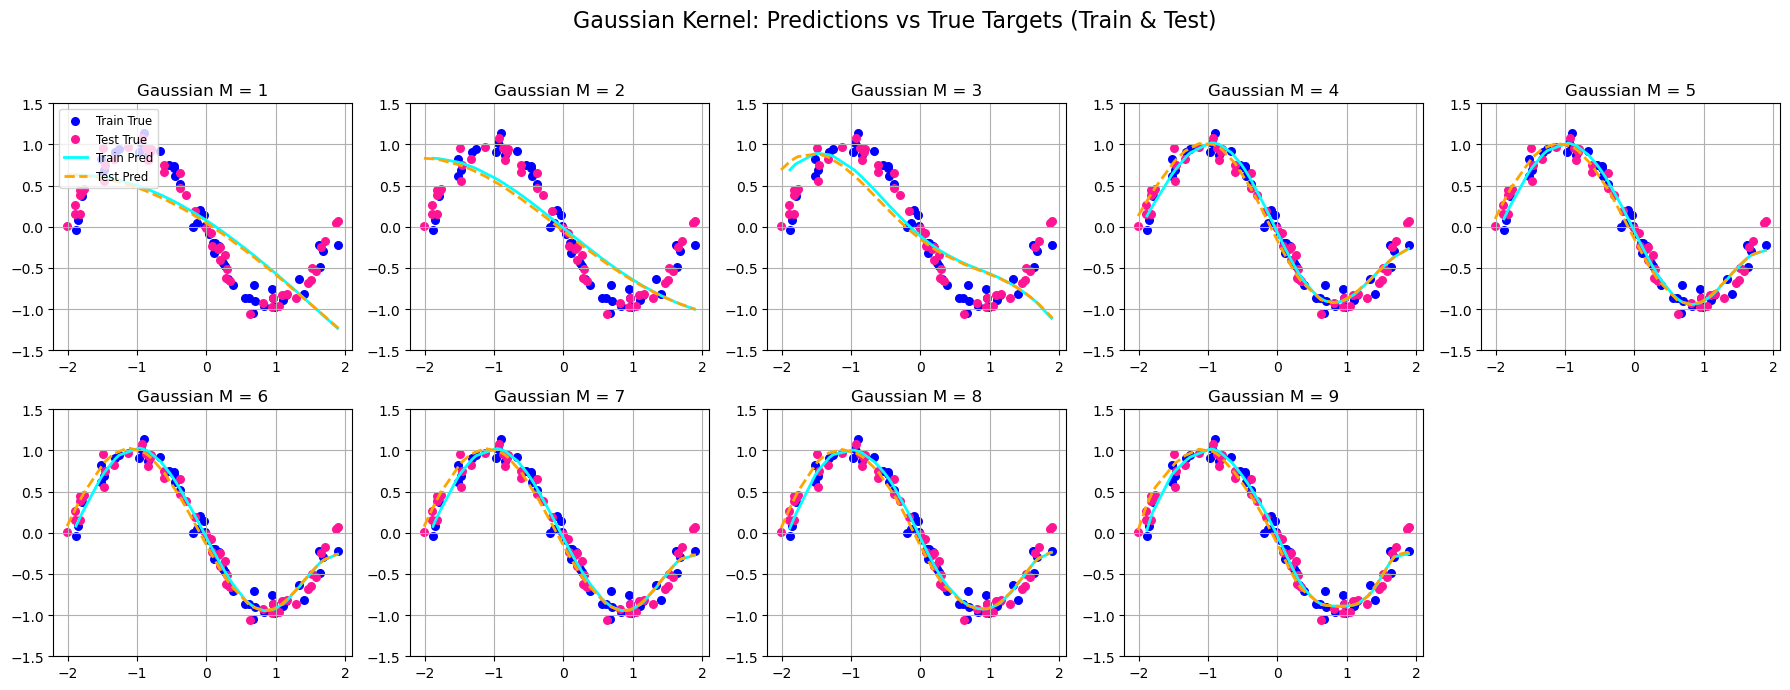

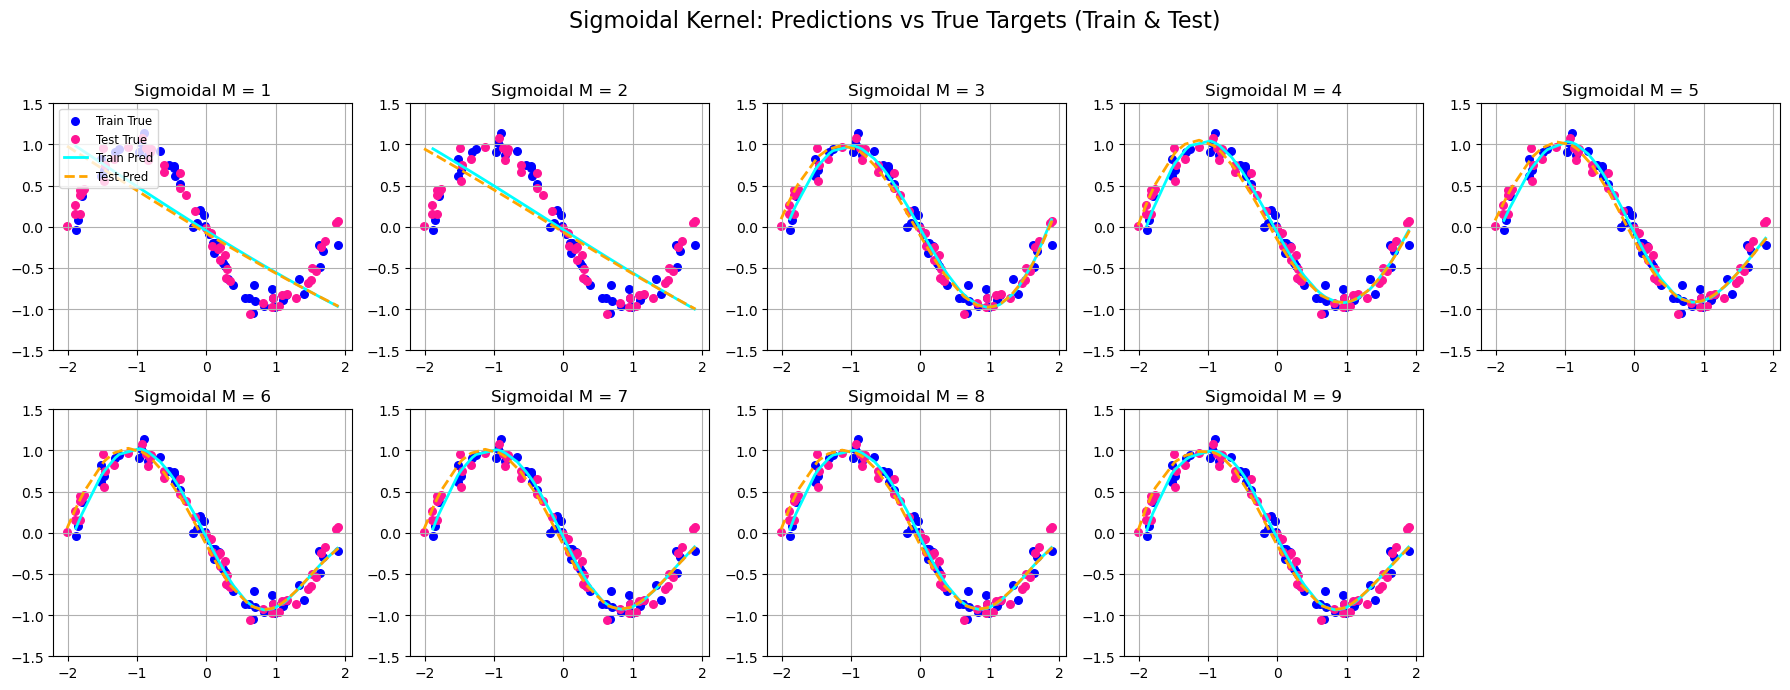

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Generic function to plot results for a given kernel
def plot_kernel_predictions(M_range, TrPred_list, TePred_list, X_train, Y_train, X_test, Y_test, kernel_name, color_train='cyan', color_test='orange'):
    num_rows = 2
    num_cols = 5

    plt.figure(figsize=(18, 7))
    for i, M in enumerate(M_range):
        plt.subplot(num_rows, num_cols, i + 1)

        train_sort = np.argsort(X_train)
        test_sort = np.argsort(X_test)

        # Actual values
        plt.scatter(X_train, Y_train, color='blue', label='Train True', s=30)
        plt.scatter(X_test, Y_test, color='deeppink', label='Test True', s=30)

        # Predicted values
        plt.plot(X_train[train_sort], TrPred_list[i][train_sort], color=color_train, label='Train Pred', linewidth=2)
        plt.plot(X_test[test_sort], TePred_list[i][test_sort], color=color_test, linestyle='--', label='Test Pred', linewidth=2)

        plt.title(f'{kernel_name} M = {M}')
        plt.ylim(-1.5, 1.5)
        plt.grid(True)

        if i == 0:
            plt.legend(loc='upper left', fontsize='small')

    plt.suptitle(f'{kernel_name} Kernel: Predictions vs True Targets (Train & Test)', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


plot_kernel_predictions(M_range, polynomial_tr_pred, polynomial_te_pred, X_train, Y_train, X_test, Y_test, kernel_name='Polynomial')
plot_kernel_predictions(M_range, gaussian_tr_pred, gaussian_te_pred, X_train, Y_train, X_test, Y_test, kernel_name='Gaussian')
plot_kernel_predictions(M_range, sigmoid_tr_pred, sigmoid_te_pred, X_train, Y_train, X_test, Y_test, kernel_name='Sigmoidal')

1. Polynomial kernel gives high training and test errors for lower order models. As model order is increased, training and test errors decrease significantly. But, it may overfit if model order is increased beyond a certain limit. If optimal model order is chosen, this kernel performs fairly well.

2. Gaussian kernel gives high training and test errors for lower order models. Choosing optimal sigma (bandwidth) is very crucial in gaussian kernel as it significantly affects model performance.

3. Sigmoid kernel performs very similar to Gaussian kernel. Here also, chosing the coefficient 'a' is crucial for model performance. After a certain M , the training and test error plateuas, and not change much even on increasing model complexity.

In [8]:
# Repeating the experiments for part b

M_range=list(range(1,10))

polynomial_tr_error1 = []
polynomial_te_error1 = []
gaussian_tr_error1 = []
gaussian_te_error1 = []
sigmoid_tr_error1 = []
sigmoid_te_error1 = []

polynomial_tr_pred1= []
polynomial_te_pred1 = []
gaussian_tr_pred1 = []
gaussian_te_pred1 = []
sigmoid_tr_pred1 = []
sigmoid_te_pred1 = []

for m in  M_range:
  w_polynomial = KernelRegressionFit(X_train1,Y_train1,'polynomial',m,0)
  Y_train_pred , Y_test_pred = KernelRegressionPred(w_polynomial, X_train1, Y_train1, X_test1, Y_test1,'polynomial')
  tr_err, te_err = KernelRegressionPred_Error(w_polynomial,X_train1,Y_train1,X_test1,Y_test1,'polynomial')
  polynomial_tr_error1.append(tr_err)
  polynomial_te_error1.append(te_err)
  polynomial_tr_pred1.append(Y_train_pred)
  polynomial_te_pred1.append(Y_test_pred)

  w_gaussian = KernelRegressionFit(X_train1,Y_train1,'gaussian',m,0)
  Y_train_pred , Y_test_pred = KernelRegressionPred(w_gaussian, X_train1, Y_train1, X_test1, Y_test1,'gaussian')
  tr_err, te_err = KernelRegressionPred_Error(w_gaussian,X_train1,Y_train1,X_test1,Y_test1,'gaussian')
  gaussian_tr_error1.append(tr_err)
  gaussian_te_error1.append(te_err)
  gaussian_tr_pred1.append(Y_train_pred)
  gaussian_te_pred1.append(Y_test_pred)

  w_sigmoidal= KernelRegressionFit(X_train1,Y_train1,'sigmoidal',m,0)
  Y_train_pred , Y_test_pred = KernelRegressionPred(w_sigmoidal, X_train1, Y_train1, X_test1, Y_test1,'sigmoidal')
  tr_err, te_err = KernelRegressionPred_Error(w_sigmoidal,X_train1,Y_train1,X_test1,Y_test1,'sigmoidal')
  sigmoid_tr_error1.append(tr_err)
  sigmoid_te_error1.append(te_err)
  sigmoid_tr_pred1.append(Y_train_pred)
  sigmoid_te_pred1.append(Y_test_pred)